<a href="https://colab.research.google.com/github/mffajardor/Alura_Bootcamp/blob/main/01_Challenge_Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge No 1: Robot Trading

## Parte 1: Configuración del ambiente

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Instalación y muestra de versiones de librerias

!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'


Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


In [ ]:
# Definición de variables Globales
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

## Parte 2: Obtención de datos

## 2.1 Precios Históricos del Bitcoin

In [ ]:
# Importar libreria yfinance para obtención de valores de divisas
import yfinance as yf

def importar_base_bitcoin():
  """
  Esta función se encarga de obtener los valores bases del bitcoin para un período determinado
  """

  # Redefiniendo variables globales aqui:
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

  # Extracción del histórico de precios del Bitcoin en dólares
  simbolo_btc = "BTC-USD"

  # Definición de los intervalos de tiempo y período de tiempo para analizar
  intervalo_tiempo = "5m"
  periodo_tiempo = "7d"

  # Descarga de los datos historicos
  datos_historicos = yf.Ticker(simbolo_btc).history(period= periodo_tiempo, interval= intervalo_tiempo)

  # Creación del dataframe de bitcoins
  df_bitcoin = pd.DataFrame(datos_historicos)

  return df_bitcoin


In [ ]:
base_bitcoin = importar_base_bitcoin()
base_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-28 00:00:00+00:00,33907.722656,33908.394531,33901.078125,33908.394531,0,0.0,0.0
2023-10-28 00:05:00+00:00,33908.644531,33914.089844,33908.644531,33913.484375,0,0.0,0.0
2023-10-28 00:10:00+00:00,33912.328125,33913.753906,33905.414062,33906.546875,0,0.0,0.0
2023-10-28 00:15:00+00:00,33898.480469,33898.480469,33885.460938,33885.460938,0,0.0,0.0
2023-10-28 00:20:00+00:00,33875.285156,33886.210938,33875.285156,33886.210938,0,0.0,0.0


## 2.2 Indicadores de Tendencias

In [ ]:
# Importación de librerias para Web Scrapping
from bs4 import BeautifulSoup
import requests

In [ ]:
def extraer_tendencias():
  """
  Esta función se encarga de extraer la tendencias de las diferentes criptomonedas
  """

  # Redefiniendo variables globales aqui:
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

  # Defino los Headers
  headers =  {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36 OPR/102.0.0.0'}

  # Sitio web para hacerle Web Scraping
  url = 'https://coinmarketcap.com/'

  # Traigo la petición del sitio web
  respuesta = requests.get(url, headers= headers)

  # Uso de bs4
  s = BeautifulSoup(respuesta.content, features = 'lxml')

  # Uso de FindAll => Encontrar todos los elementos con la clase coin-item-symbol
  respuesta = s.findAll('p', {'class': 'sc-4984dd93-0 iqbdQL coin-item-symbol'})
  # print(respuesta)
  indice = 0

  # Ciclo for para el conteo de indices
  for item in respuesta:
    if item.getText() == 'BTC':
      break
    indice += 1

  respuesta = s.findAll('div', {'class': ['sc-a0353bbc-0 gDrtaY','sc-a0353bbc-0 gDrtaY rise','sc-a0353bbc-0 gDrtaY fall']})
  # print(respuesta)
  precio_actual = float(respuesta[indice].getText().replace('$','').replace(',',''))

  # Creo una lista para almacenar los valores de las etiquetas span
  lista = []
  respuesta = s.findAll('span', {'class': ['sc-d55c02b-0 iwhBxy', 'sc-d55c02b-0 gUnzUB']})

  for item in respuesta[::3]:
    lista.append(item)

  tendencia = ''

  # Condicional para identificar si la tendencia es al alza o a la baja
  if lista[indice].find('span')['class'][0] == 'icon-Caret-up':
    tendencia = 'alta'
  else:
    tendencia = 'baja'



In [ ]:
# Muestra del Precio Actual del Bitcoin y su tendencia
extraer_tendencias()
print(f"Bitcoin Price: {precio_actual}")
print(f"Tendencia: {tendencia}")

Bitcoin Price: 34636.95
Tendencia: alta


# Parte 3: Limpieza de Datos

In [ ]:
def limpieza_datos():
  """
  Esta función se encargará de tomar el dataframe df_bitcoin y realizar la eliminación de valores nulos y outliers
  """
  # Rellamo a las variables gloables
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

  # Realizo la copia a mi dataframe y reinicio los indices
  df_bitcoin_processed = df_bitcoin.copy()
  df_bitcoin_processed = df_bitcoin_processed.reset_index()

  # Obtención de valores unicos de la columna "Datetime"
  df_bitcoin_processed = df_bitcoin_processed.drop_duplicates(subset=['Datetime'])

  # Eliminación de los valores nulos
  df_bitcoin_processed = df_bitcoin_processed[df_bitcoin_processed['Close'].notnull()]

  # Obtención de Valores de la columna "Volume" mayores a 0
  seleccion = df_bitcoin_processed['Volume']>0
  df_bitcoin_processed = df_bitcoin_processed[seleccion]

  # Obtengo los valores para realizar el boxplot entre Q1 y Q3 y eliminar outliers

  precios = df_bitcoin_processed['Close']
  Q1 = precios.quantile(0.25)
  Q3 = precios.quantile(0.75)

  values_box = (precios >= Q1) & (precios <= Q3)
  df_bitcoin_processed = df_bitcoin_processed[values_box]
  df_bitcoin_processed = df_bitcoin_processed.reset_index(drop=True)

  # Calculo de la media
  media_bitcoin = df_bitcoin_processed['Close'].mean()

  return df_bitcoin_processed, media_bitcoin



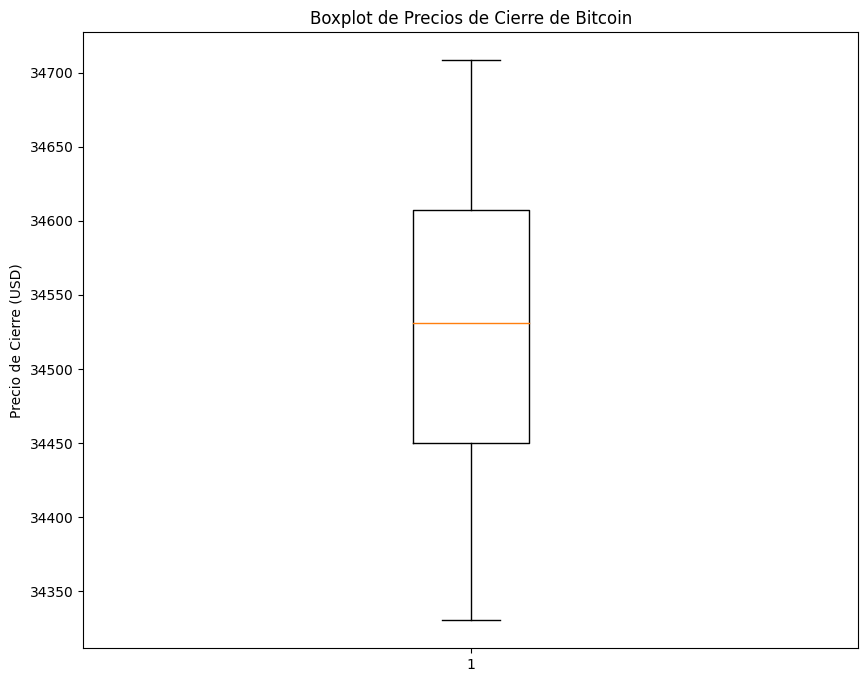

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,Promedio
0,2023-10-28 11:20:00+00:00,34178.871094,34399.390625,34178.871094,34332.750000,155396096,0.0,0.0,34527.52877
1,2023-10-28 11:25:00+00:00,34372.828125,34372.828125,34312.792969,34342.476562,283971584,0.0,0.0,34527.52877
2,2023-10-28 11:30:00+00:00,34319.300781,34360.351562,34319.300781,34360.351562,83885056,0.0,0.0,34527.52877
3,2023-10-29 12:05:00+00:00,34283.597656,34349.570312,34283.597656,34340.210938,33045504,0.0,0.0,34527.52877
4,2023-10-29 12:35:00+00:00,34334.828125,34339.492188,34334.070312,34334.070312,1885184,0.0,0.0,34527.52877
...,...,...,...,...,...,...,...,...,...
458,2023-11-03 02:00:00+00:00,34613.335938,34636.953125,34579.746094,34636.953125,2535424,0.0,0.0,34527.52877
459,2023-11-03 02:05:00+00:00,34660.085938,34660.085938,34633.023438,34633.023438,18741248,0.0,0.0,34527.52877
460,2023-11-03 02:10:00+00:00,34643.992188,34648.031250,34641.695312,34641.695312,6793216,0.0,0.0,34527.52877
461,2023-11-03 02:25:00+00:00,34667.339844,34702.941406,34667.339844,34702.941406,1982464,0.0,0.0,34527.52877


In [ ]:
df_bitcoin_proc, bitcoin_mean = limpieza_datos()


plt.figure(figsize= (10,8))
plt.boxplot(df_bitcoin_proc['Close'])
plt.title('Boxplot de Precios de Cierre de Bitcoin')
plt.ylabel('Precio de Cierre (USD)')
plt.show()

df_bitcoin_proc


In [ ]:
print(f"El valor promedio de cierre es: {media_bitcoin}")

El valor promedio de cierre es: 34527.52876957344


# Parte 4: Tomar decisiones

## 4.1 Toma de Decisiones

In [ ]:
def tomar_decisiones():
  global algoritmo_decision, precio_actual, media_bitcoin, tendencia

  if precio_actual >= media_bitcoin and tendencia == "baja":
    algoritmo_decision = "Vender"

  elif precio_actual < media_bitcoin and tendencia == "alta":
    algoritmo_decision = "Comprar"

  else:
    algoritmo_decision = "Esperar"

  return algoritmo_decision

In [ ]:
decision = tomar_decisiones()
print(f"La decisión recomendable en este momento es: {decision}")

La decisión recomendable en este momento es: Esperar


# Parte 5: Visualización

In [ ]:
def visualizacion():

  # Llamamos las variables globales a usar
  global algoritmo_decision, df_bitcoin, media_bitcoin

  colores_decision = {
      "Vender": 'green',
      "Comprar": 'red',
      "Esperar": 'black'
  }

  # Determinar el color basado en la decisión del algoritmo
  color_dec = colores_decision.get(algoritmo_decision, 'black')

  # Añado una nueva columna a df_bitcoin => Almacena el valor del promedio obtenido
  df_bitcoin['Promedio'] = media_bitcoin

  # Configuro el lienzo para gráficar
  plt.figure(figsize = (16, 5))
  plt.title("Tendencia de Decisión - Bitcoin")

  # Grafica del precio de cierre
  plt.plot(df_bitcoin.index, df_bitcoin.Close, label = "Cierre")

  # Grafica del promedio del bitcoin
  plt.plot(df_bitcoin.index, df_bitcoin.Promedio, label = "Promedio")

  # Realizo la anotación a partir del resultado del algoritmo de decisión
    # Anotación a partir del resultado del algoritmo de decisión
  plt.annotate(
      f'{algoritmo_decision}',
      xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),
      xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1] * 1.05),
      arrowprops=dict(facecolor=color_dec, shrink=0.05),
      fontsize=12, color=color_dec,
      bbox=dict(boxstyle="round,pad=0.3", edgecolor=color_dec, facecolor='white')
    )

  # Mostrar el gráfico
  plt.ylabel("Precio - BTC")
  plt.xlabel("Fecha")
  plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
  plt.grid()
  plt.show()

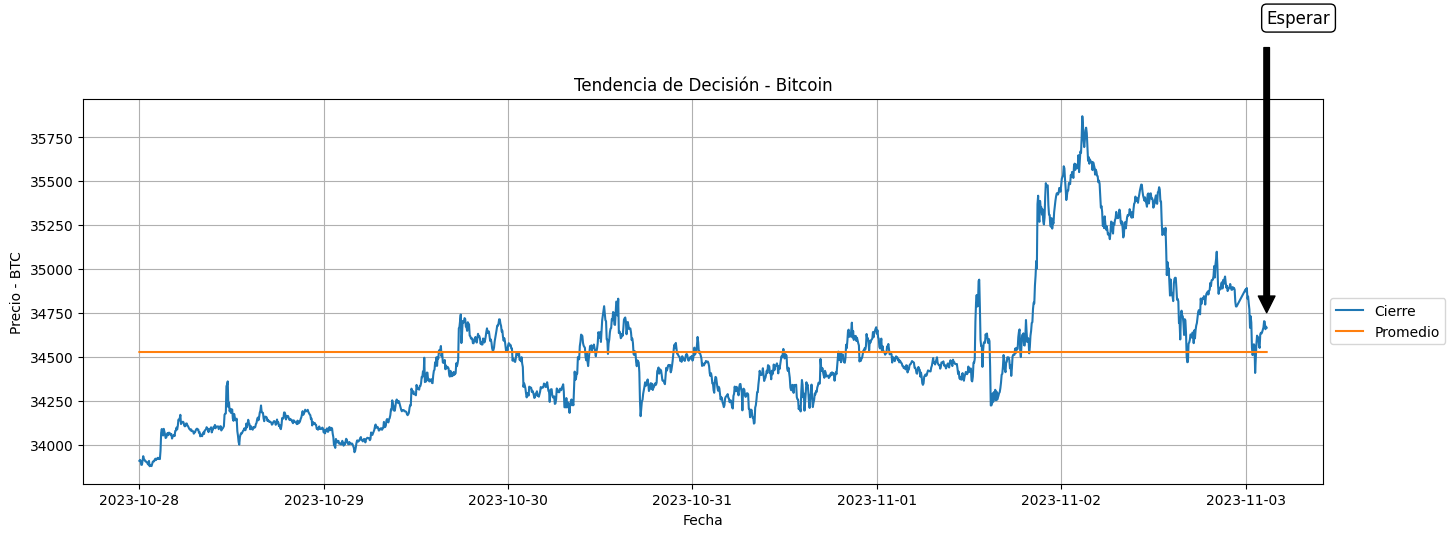

In [ ]:
visualizacion()

# 6. Automatización

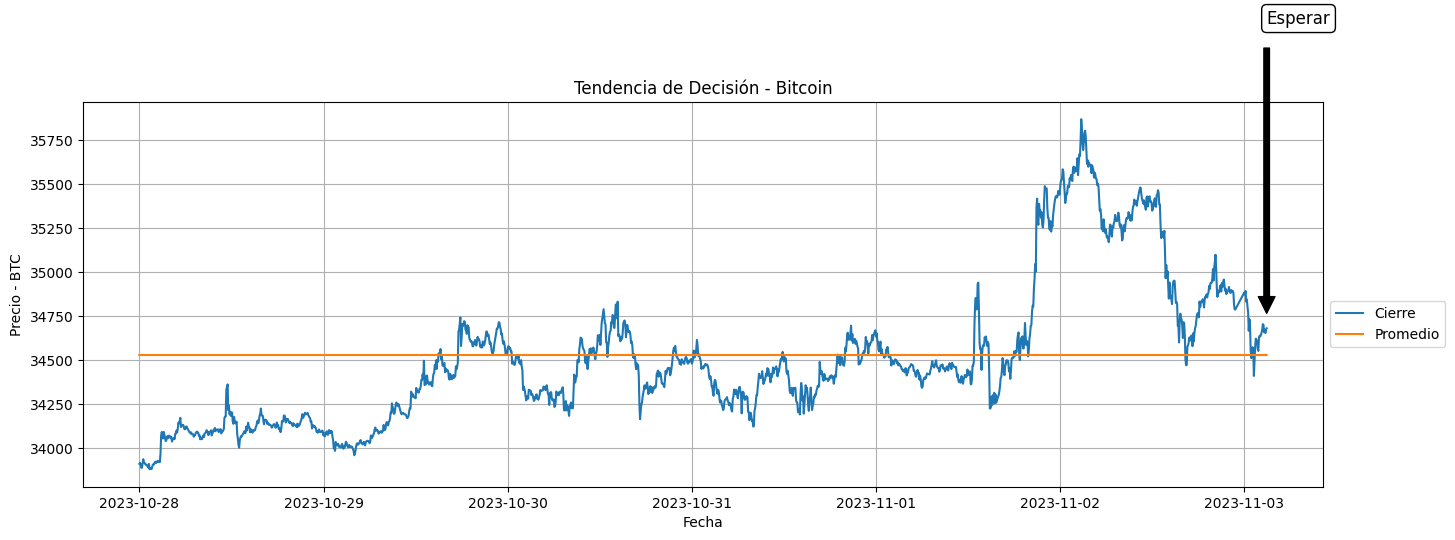

In [ ]:
from IPython.display import clear_output
import time


# Ciclo infinito donde se ejecutan las diferentes funciones desarrolladas

while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)